# Universal inverse problem 

In [2]:
import numpy as np
from skimage.metrics import structural_similarity
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from BF_CNN import *
from algorithm_inv_prob import *

%matplotlib inline

### Choose a denoiser


In [2]:

denoiser = 'BF_CNN'
noise_level_range = [0,100]


In [3]:

all_params = {
'epochs': 50,
"learning_rate" : .001,
'parent_included': 'not applicable',
'kernel_size_waves': 'not applicable',

"kernel_size_mid" : 3,
"padding_mid" : 1,
"num_mid_kernels" : 64,
"num_mid_layers" : 20,

"batch_size" : 128,
"patch_size" : (50,50),
"patching_strides" : (10,10),
'scales' : [1,.9,.8,.7],
}

model = Net(all_params)
if torch.cuda.is_available():
    model = model.cuda()


all_params['dir_name'] = 'denoisers/'+denoiser+'/noise_range_' + str(noise_level_range[0])+'to'+ str(noise_level_range[1])


best_model = all_params['dir_name']+'/model.pt'
if torch.cuda.is_available():
    learned_params =torch.load(best_model)
    running_sd = torch.load(all_params['dir_name']+'/running_sd.pt')

else:
    learned_params =torch.load(best_model, map_location='cpu' )
    running_sd = torch.load(all_params['dir_name']+'/running_sd.pt', map_location='cpu')


model.load_state_dict(learned_params)
for i in range(all_params['num_mid_layers']-2):
    model.running_sd[i] = running_sd[i]
model.eval();

# Synthesis

In [6]:
freq = 5
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(np.zeros((40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = 1,          
                                    save_interm=True)



----------------------------- 5
sigma  0.8889278885375116
----------------------------- 10
sigma  0.6331329939078351
----------------------------- 15
sigma  0.3591978402544318
----------------------------- 20
sigma  0.16332113643397717
----------------------------- 25
sigma  0.05360190370449538
----------------------------- 30
sigma  0.012962393774732578
-------- total number of iterations,  32
-------- average time per iteration (s),  0.0658


value range 0.14 1.0


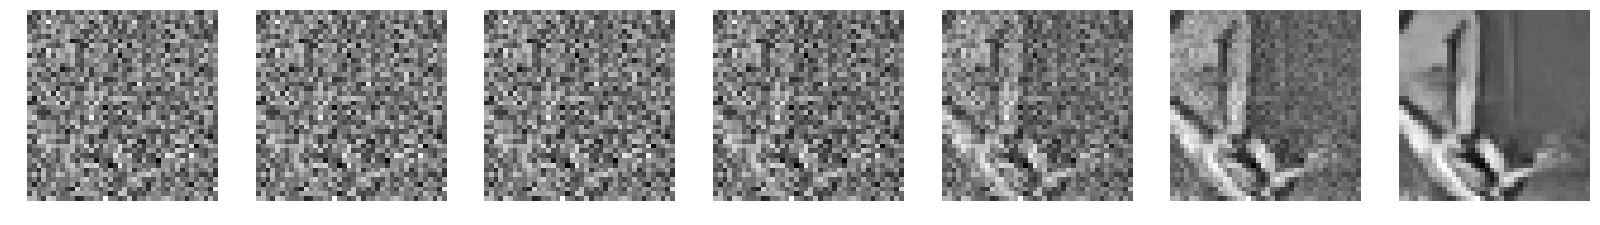

In [8]:

f, axs = plt.subplots(1,len(intermed_Ys), figsize = ( 4*len(intermed_Ys),4))
axs = axs.ravel()

for ax in range(len(intermed_Ys)): 
    fig = axs[ax].imshow(intermed_Ys[ax], 'gray')
    axs[ax].axis('off')
fig = axs[-1].imshow(sample, 'gray')
axs[-1].axis('off')
print('value range', np.round(np.min(sample),2), np.round(np.max(sample)))        

# Conditionals 

### load an example image

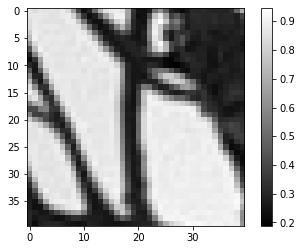

In [8]:
test_folder_path = 'data/Test/Set68/'
set12_path =       'data/Test/Set12/'


x = single_image_loader(test_folder_path, 15)[100:140,100:140]

plt.imshow(x, 'gray')
plt.colorbar()

## Inpainting

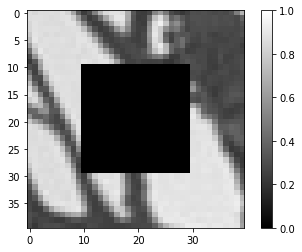

In [9]:
x = single_image_loader(test_folder_path, 15)[100:140, 100:140]

inpaint = inpainting(x.shape)

plt.imshow(inpaint.M(inpaint.M_T(x)), 'gray', vmin=0, vmax = 1)
plt.colorbar()

In [10]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= inpaint.M_T(x), 
                                    M_T= inpaint.M_T,
                                    M = inpaint.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=True)

----------------------------- 20
sigma  1.0177591120444454
----------------------------- 40
sigma  0.8865921424568309
----------------------------- 60
sigma  0.7613791789037594
----------------------------- 80
sigma  0.6368343208611613
----------------------------- 100
sigma  0.5946927502148671
----------------------------- 120
sigma  0.5266404685998701
----------------------------- 140
sigma  0.34229895171866487
----------------------------- 160
sigma  0.23999711247803962
----------------------------- 180
sigma  0.19213165293065787
----------------------------- 200
sigma  0.14221581017993754
----------------------------- 220
sigma  0.08356252124158346
----------------------------- 240
sigma  0.04613288423400482
----------------------------- 260
sigma  0.015191798765552739
-------- total number of iterations,  265
-------- average time per iteration (s),  0.0676


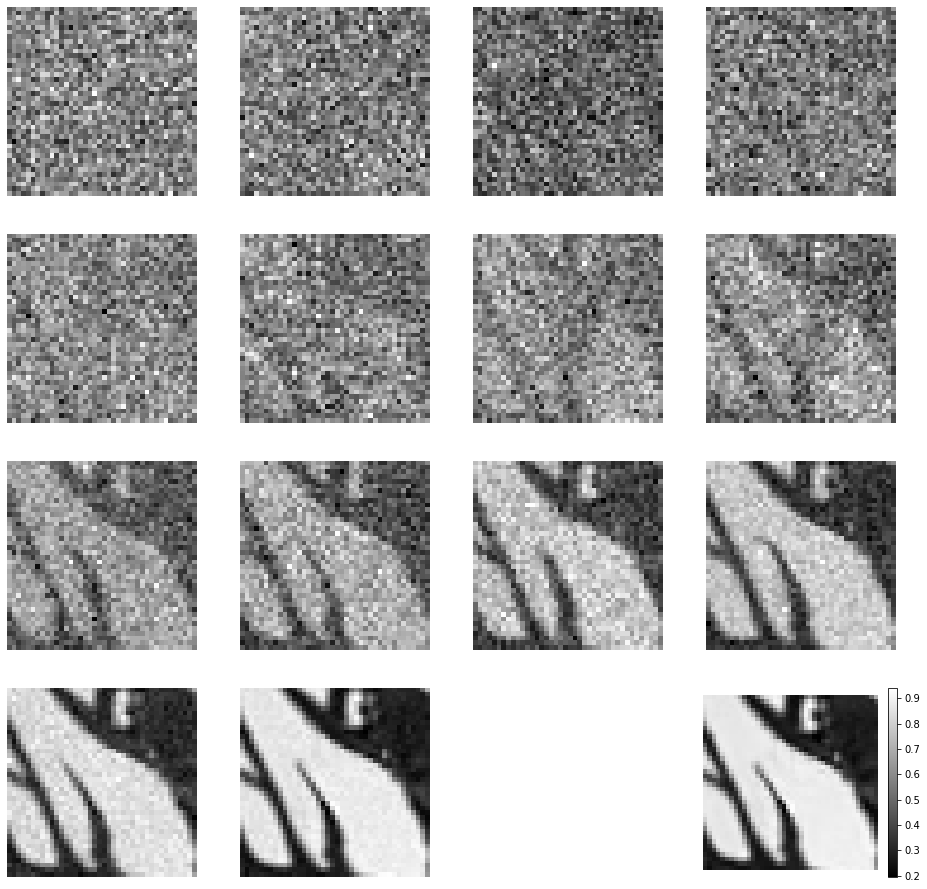

In [16]:
n_rows = int(np.ceil(len(intermed_Ys)/4))

f, axs = plt.subplots(n_rows,4, figsize = ( 4*4, n_rows*4))
axs = axs.ravel()

for ax in range(len(intermed_Ys)): 
    fig = axs[ax].imshow(intermed_Ys[ax], 'gray')
    axs[ax].axis('off')

fig = axs[-1].imshow(sample, 'gray')
axs[-1].axis('off')
plt.colorbar(fig, ax=axs[-1], fraction=.05)


for ax in range(len(intermed_Ys),n_rows*4 ): 
    axs[ax].axis('off')





## Random basis

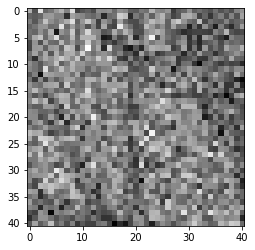

In [23]:
x = single_image_loader(test_folder_path, 15)[100:141, 100:141]

rand_basis = random_basis(x.shape , .5)

plt.imshow(rand_basis.M(rand_basis.M_T(x)), 'gray')
# plt.colorbar()

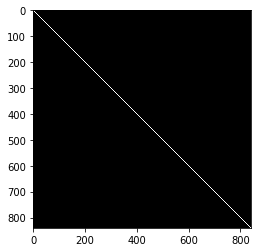

In [24]:

plt.imshow(np.dot(rand_basis.U.T,rand_basis.U), 'gray')


In [25]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_basis.M_T(x), 
                                    M_T= rand_basis.M_T,
                                    M = rand_basis.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=True)

----------------------------- 20
sigma  1.0029257854205507
----------------------------- 40
sigma  1.0181249828728676
----------------------------- 60
sigma  0.8160412435942824
----------------------------- 80
sigma  0.7197436677271116
----------------------------- 100
sigma  0.49701622102355125
----------------------------- 120
sigma  0.33099622659529254
----------------------------- 140
sigma  0.19642782514382007
----------------------------- 160
sigma  0.10586698857894006
----------------------------- 180
sigma  0.038055116163302795
-------- total number of iterations,  194
-------- average time per iteration (s),  0.0748


Text(0.5, 1.0, 'reconstructed, PSNR 34.16')

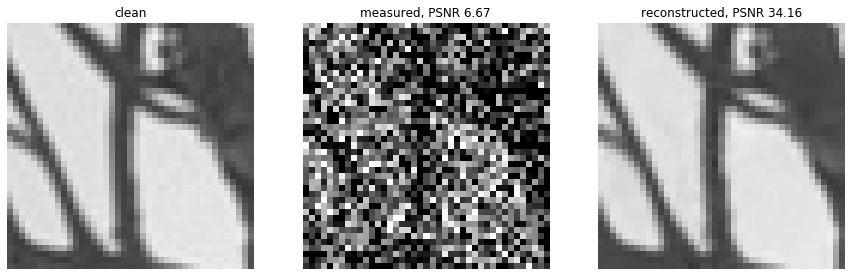

In [20]:
f, axs = plt.subplots(1,3, figsize = (15,5))
axs = axs.ravel()

fig = axs[0].imshow( x, 'gray', vmin=0, vmax = 1)
axs[0].axis('off')
axs[0].set_title('clean')

fig = axs[1].imshow(rand_basis.M(rand_basis.M_T(x)) , 'gray', vmin=0, vmax = 1)
axs[1].axis('off')
axs[1].set_title('measured, PSNR ' + str(np.round(PSNR(x,rand_basis.M(rand_basis.M_T(x)) ),2)))


axs[2].imshow(sample , 'gray',vmin=0, vmax = 1)
axs[2].axis('off');
axs[2].set_title('reconstructed, PSNR '+ str(np.round(PSNR(x,sample),2)) )


## random pixel drop


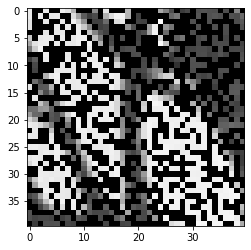

In [27]:
x = single_image_loader(test_folder_path, 15)[100:140, 100:140]

rand_pix = rand_pixels(x.shape, .5)
plt.imshow(rand_pix.M(rand_pix.M_T(x)), 'gray')

In [28]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_pix.M_T(x), 
                                    M_T= rand_pix.M_T,
                                    M = rand_pix.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.001,          
                                    save_interm=True)

----------------------------- 20
sigma  0.9775203693590576
----------------------------- 40
sigma  0.8927145778777055
----------------------------- 60
sigma  0.8002698633729839
----------------------------- 80
sigma  0.6501688609061607
----------------------------- 100
sigma  0.39315020157687225
----------------------------- 120
sigma  0.21443582796151697
----------------------------- 140
sigma  0.11294785922212616
----------------------------- 160
sigma  0.048911869583214286
-------- total number of iterations,  178
-------- average time per iteration (s),  0.067


Text(0.5, 1.0, 'reconstructed \n psnr: 29.57')

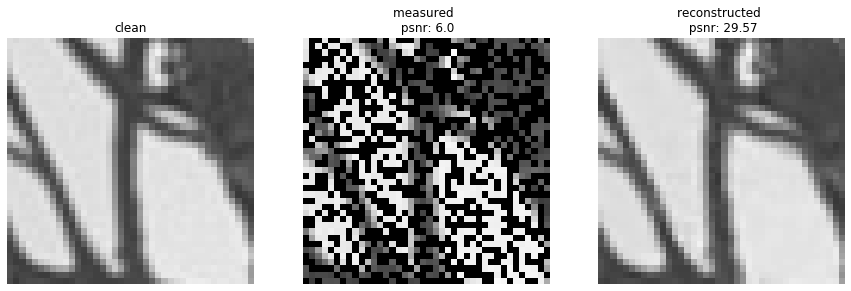

In [29]:
f, axs = plt.subplots(1,3, figsize = (15,5))
axs = axs.ravel()

fig = axs[0].imshow( x, 'gray', vmin=0, vmax = 1)
axs[0].axis('off')
axs[0].set_title('clean')

fig = axs[1].imshow(rand_pix.M(rand_pix.M_T(x)) , 'gray')
axs[1].axis('off')
axs[1].set_title('measured')
axs[1].set_title('measured \n psnr: '+str(np.round(PSNR(x, rand_pix.M(rand_pix.M_T(x)) ))))


axs[2].imshow(sample , 'gray',vmin=0, vmax = 1)
axs[2].axis('off');
axs[2].set_title('reconstructed')
axs[2].set_title('reconstructed \n psnr: '+str(np.round(PSNR(x,sample),2) ) )


## super resolution 2x

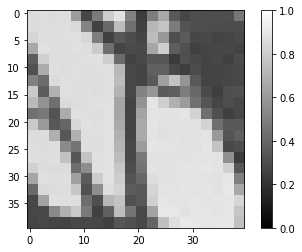

In [30]:
s=2
x = single_image_loader(test_folder_path, 15)[100:140,100:140]

super_res = super_resolution(x.shape, 2)

plt.imshow(super_res.M(super_res.M_T(x)), 'gray', vmin=0, vmax = 1)
plt.colorbar()




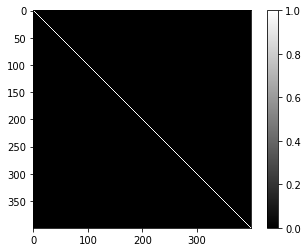

In [31]:
plt.imshow(np.dot(super_res.down_sampling.T,super_res.down_sampling), 'gray')
plt.colorbar()

In [32]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.03, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.001,          
                                    save_interm=True)



----------------------------- 20
sigma  0.9668993890529732
----------------------------- 40
sigma  0.913630613271447
----------------------------- 60
sigma  0.7484176570007421
----------------------------- 80
sigma  0.5830060816644632
----------------------------- 100
sigma  0.47625971805975736
----------------------------- 120
sigma  0.40678789974584095
----------------------------- 140
sigma  0.29080878519929015
----------------------------- 160
sigma  0.21323155268271377
----------------------------- 180
sigma  0.10023270209099407
-------- total number of iterations,  199
-------- average time per iteration (s),  0.0681


Text(0.5, 1.0, 'reconstructed \n psnr: 28.03\n ssim 0.968')

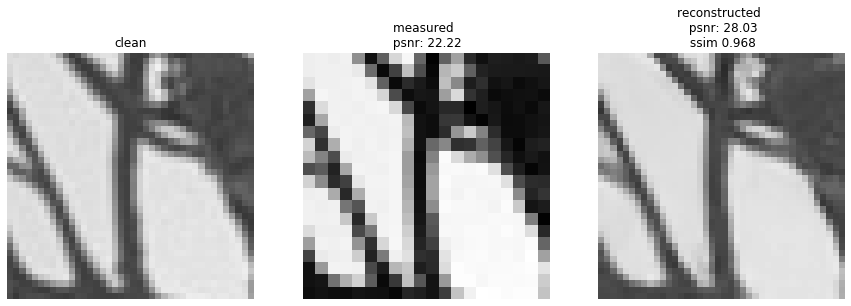

In [33]:
f, axs = plt.subplots(1,3, figsize = (15,5))
axs = axs.ravel()

fig = axs[0].imshow( x, 'gray', vmin=0, vmax = 1)
axs[0].axis('off')
axs[0].set_title('clean')

fig = axs[1].imshow( super_res.M(super_res.M_T(x)) , 'gray')
axs[1].axis('off')
axs[1].set_title('measured')
axs[1].set_title('measured \n psnr: '+str(np.round(PSNR(x,super_res.M(super_res.M_T(x)) ),2)))


axs[2].imshow(sample , 'gray',vmin=0, vmax = 1)
axs[2].axis('off');
axs[2].set_title('reconstructed')
axs[2].set_title('reconstructed \n psnr: '+str(np.round(PSNR(x,sample),2))+ '\n ssim '+str(np.round(structural_similarity(x,sample) ,3)))


## super resolution 4x

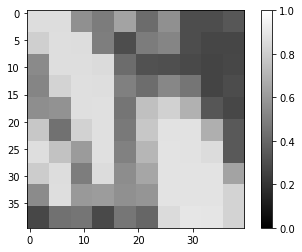

In [34]:
s=4
x = single_image_loader(test_folder_path, 15)[100:140,100:140]

super_res = super_resolution(x.shape, s)

plt.imshow(super_res.M(super_res.M_T(x)), 'gray', vmin=0, vmax = 1)
plt.colorbar()




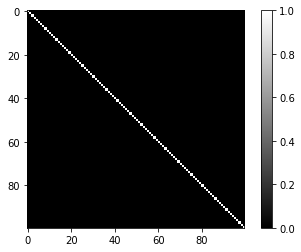

In [35]:
plt.imshow(np.dot(super_res.down_sampling.T,super_res.down_sampling), 'gray')
plt.colorbar()

In [36]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.03, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.001,          
                                    save_interm=True)



----------------------------- 20
sigma  0.9490019919135102
----------------------------- 40
sigma  0.8210050026485154
----------------------------- 60
sigma  0.5678967654438547
----------------------------- 80
sigma  0.3612229897565207
----------------------------- 100
sigma  0.2631752546450129
----------------------------- 120
sigma  0.1332398707033658
----------------------------- 140
sigma  0.026202595712397463
-------- total number of iterations,  141
-------- average time per iteration (s),  0.0673


Text(0.5, 1.0, 'reconstructed \n psnr: 20.894127473129096')

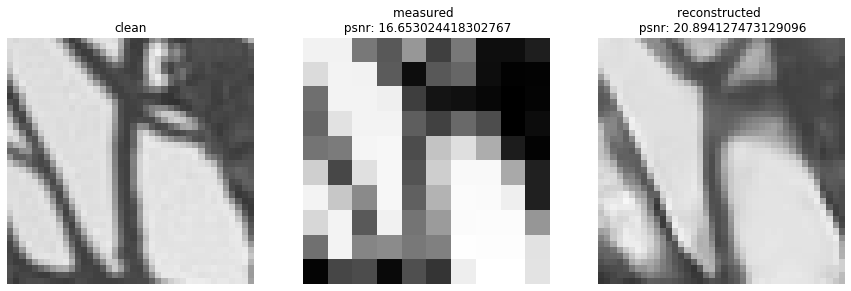

In [37]:
f, axs = plt.subplots(1,3, figsize = (15,5))
axs = axs.ravel()

fig = axs[0].imshow( x, 'gray', vmin=0, vmax = 1)
axs[0].axis('off')
axs[0].set_title('clean')

fig = axs[1].imshow( super_res.M(super_res.M_T(x)) , 'gray')
axs[1].axis('off')
axs[1].set_title('measured')
axs[1].set_title('measured \n psnr: '+str(PSNR(x,super_res.M(super_res.M_T(x)) )))


axs[2].imshow(sample , 'gray',vmin=0, vmax = 1)
axs[2].axis('off');
axs[2].set_title('reconstructed')
axs[2].set_title('reconstructed \n psnr: '+str(PSNR(x,sample)))


## spectural super resolution

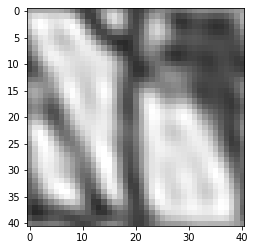

In [38]:
# only works for square images. FIX IT

x = single_image_loader(test_folder_path, 15)[100:141,100:141]

spec_super_res = spectral_super_resolution(low_pass=True, im_d=x.shape[0], filt_size=int(x.shape[0]/3))

plt.imshow(spec_super_res.M(spec_super_res.M_T(x) ), 'gray', vmin=0, vmax = 1)
    

In [39]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=spec_super_res.M_T(x), 
                                    M_T= spec_super_res.M_T,
                                    M = spec_super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.005,          
                                    save_interm=True)



----------------------------- 20
sigma  0.9415564191326613
----------------------------- 40
sigma  0.835652227530516
----------------------------- 60
sigma  0.6088662588723184
----------------------------- 80
sigma  0.4798829479831866
----------------------------- 100
sigma  0.2797963987724192
----------------------------- 120
sigma  0.14650755005369148
----------------------------- 140
sigma  0.035450443445143545
-------- total number of iterations,  149
-------- average time per iteration (s),  0.071


Text(0.5, 1.0, 'reconstructed 24.36')

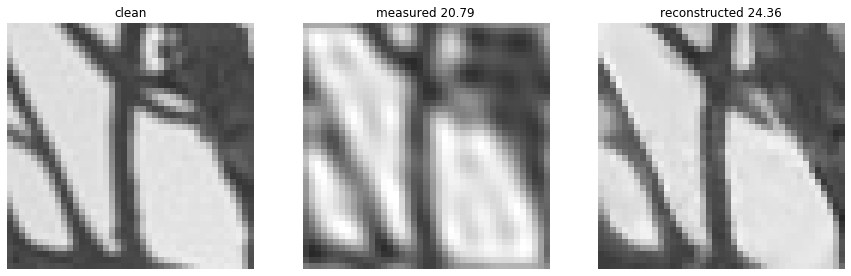

In [34]:
f, axs = plt.subplots(1,3, figsize = (15,5))
axs = axs.ravel()

fig = axs[0].imshow( x, 'gray', vmin=0, vmax = 1)
axs[0].axis('off')
axs[0].set_title('clean')

fig = axs[1].imshow(spec_super_res.M(spec_super_res.M_T(x) ), 'gray',vmin=0, vmax = 1)
axs[1].axis('off')
axs[1].set_title('measured '+ str(np.round(PSNR(spec_super_res.M(spec_super_res.M_T(x) ) ,x),2) ))


axs[2].imshow(sample , 'gray',vmin=0, vmax = 1)
axs[2].axis('off');
axs[2].set_title('reconstructed '+ str(np.round(PSNR(x,sample),2) ))
